IMPORTING THE LIBRARIES

In [55]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    
import cv2
import time
import torch
import torchvision.models as models
import torch.quantization

In [56]:
import torch.nn as nn

In [57]:
device = torch.device('cuda')

In [58]:
train_images = []
Masks = []

In [59]:
from torchvision import transforms

In [60]:
print(torch.cuda.is_available())

True


In [61]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),# Converts the image to a tensor and scales pixel values to [0, 1]
])


In [63]:
masks_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:1, :, :]),
    transforms.Lambda(lambda x : x > 0.04),# Converts the image to a tensor and scales pixel values to [0, 1]
])

In [64]:
mask_transform_india= transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
      transforms.Lambda(lambda x: x[:1, :, :]),
    transforms.Lambda(lambda x : x > 0.5),# Converts the image to a tensor and scales pixel values to [0, 1]
])

In [65]:
img = Image.open("/home/bhavesh/pathpal/cane_model/image.png")
img = np.array(img)

In [66]:
img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[102, 102, 156],
        [102, 102, 156],
        [102, 102, 156],
        ...,
        [102, 102, 156],
        [102, 102, 156],
        [102, 102, 156]],

       [[102, 102, 156],
        [102, 102, 156],
        [102, 102, 156],
        ...,
        [102, 102, 156],
        [102, 102, 156],
        [102, 102, 156]],

       ...,

       [[244,  35, 232],
        [244,  35, 232],
        [244,  35, 232],
        ...,
        [244,  35, 232],
        [244,  35, 232],
        [244,  35, 232]],

       [[244,  35, 232],
        [244,  35, 232],
        [244,  35, 232],
        ...,
        [244,  35, 232],
        [244,  35, 232],
        [244,  35, 232]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [67]:
k=0
for dirpath, dirnames, filenames in os.walk(r"/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Raw_images/train"):
    print(dirpath)
    if k==0:
        k=k+1
        pass
    elif k!=0:
        items = os.listdir(dirpath)
        for item in items:
            img = Image.open(os.path.join(dirpath,item))
            train_images.append(transform(img))

/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Raw_images/train
/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Raw_images/train/1_018
/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Raw_images/train/1_012


In [68]:
len(train_images)

1464

In [ ]:
j=0
for dirpath, dirnames, filenames in os.walk(r"/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Masks/train"):
    if j==0:
        j=j+1
        pass
    elif j!=0:
        masks = os.listdir(dirpath)
        for mask in masks:
            if not mask.endswith('.png'):
                continue
            img = Image.open(os.path.join(dirpath,mask))
            Masks.append(mask_transform_india(img))

In [14]:
j=0
for dirpath, dirnames, filenames in os.walk(r"/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Masks/train"):
        print(dirpath)


/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Masks/train
/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Masks/train/1_018
/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Masks/train/1_012


In [12]:
print(len(Masks))

1464


In [13]:
train_images_city =[]
masks_city =[]

In [21]:
i=0
for dirpath, dirnames, filenames in os.walk(r"/home/bhavesh/pathpal/datasets/Road_segmentation/City_dataset_full-20240728T123354Z-001/City_dataset_full"):
    if dirnames and i==0 :
        i=i+1
        pass

    elif dirnames and i!=0 :
        path = os.path.join(dirpath,"images")
        path_masks= os.path.join(dirpath,"mask")
        items = os.listdir(path)
        masks = os.listdir(path_masks)
        count = 0
        for item in items:
            img = Image.open(os.path.join(path,item))
            train_images_city.append(transform(img))

        for mask in masks:
            if count % 3 == 1 :
                msk = os.path.join(path_masks,mask)
                msk = Image.open(msk)
                masks_city.append(masks_transform(msk))
                count =count +1
            else :
                count= count +1

In [30]:
print(len(train_images_city))
print(len(masks_city))

1213
1213


In [31]:
train_images = train_images + train_images_city
Masks = Masks + masks_city

In [34]:
len(train_images)

2677

In [35]:
# torch.tensor(train_images,dtype=torch.float32) this method is wrong u cant convert a list of tensors to a tensor u need to use stack
X_train =  torch.stack([tensor.cpu() for tensor in train_images], dim=0)
y_train =  torch.stack([tensor.float().cpu() for tensor in Masks], dim=0)

In [36]:
perm = torch.randperm(X_train.size(0))

In [37]:
X_train.size(0)

2677

In [38]:
perm

tensor([1687, 1390,  884,  ..., 1344, 1980, 1926])

In [39]:
X_train = X_train[perm]
y_train = y_train[perm]

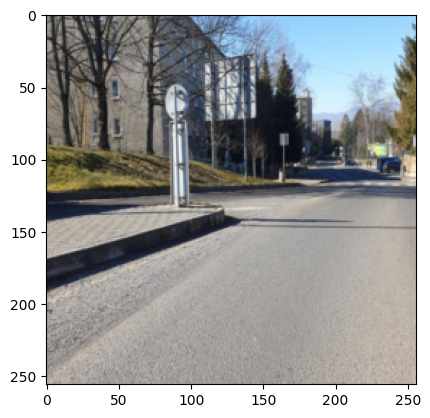

In [45]:
a = train_images_city[3].permute(1,2,0).cpu().numpy()
b = masks_city[3].permute(1,2,0).cpu().numpy()
plt.imshow(a)

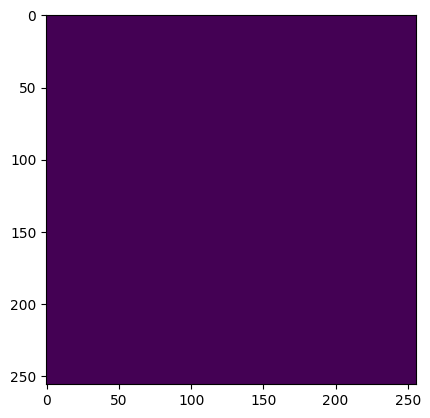

In [46]:
plt.imshow(b)

In [27]:
y_train.squeeze(dim=1).size()

torch.Size([2677, 256, 256])

In [28]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [29]:
class CustomDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask


In [30]:
from torch.utils.data import random_split


In [31]:
total_size = len(CustomDataset(X_train,y_train))
train_size = int(0.9 * total_size)  # 90% for training
val_size = total_size - train_size   # The remaining 10% for validation


In [32]:
train_dataset, val_dataset = random_split(CustomDataset(X_train,y_train), [train_size, val_size])

In [33]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= 8 ,shuffle=False)

In [34]:
def conv_block(input_channels,output_channels):
   block = nn.Sequential(
   nn.Conv2d(in_channels=input_channels,out_channels = output_channels,kernel_size=3,stride=1,padding=1),
   nn.ReLU(),
   nn.Conv2d(in_channels=output_channels,out_channels = output_channels,kernel_size=3,stride=1,padding=1),
   nn.ReLU()
   )
   return block

In [35]:
class Encoder_Block(nn.Module):
  def __init__(self,input_channels,output_channels):
    super().__init__()
    self.conv = conv_block(input_channels,output_channels)
    self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

  def forward(self,x):
    x = self.conv(x)
    p = self.maxpool(x)
    return x ,p

In [36]:
class Decoder_block(nn.Module):

  def __init__(self,input_channels,output_channels):
    super().__init__()
    self.conv_transpose = nn.ConvTranspose2d(input_channels,output_channels,kernel_size=2,stride=2,padding=0)
    self.conv = conv_block(input_channels,output_channels)

  def forward(self,x,skip_features):
    x = self.conv_transpose(x)
    x = torch.cat((x,skip_features),dim=1)
    x = self.conv(x)
    return x

In [37]:
class Encoder_block(nn.Module):

  def __init__(self,input_channels,output_channels):
    super().__init__()
    self.conv = conv_block(input_channels,output_channels)
    self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

  def forward(self,x):
    x = self.conv(x)
    p = self.maxpool(x)
    return x ,p

In [38]:
class UNET(nn.Module):
 def __init__(self):
    super().__init__()
    self.encoder1 = Encoder_block(3,64)
    self.encoder2 = Encoder_block(64,128)
    self.encoder3 = Encoder_block(128,256)
    self.encoder4 = Encoder_block(256,512)

    self.base_layer = conv_block(512,1024)

    self.decoder1 = Decoder_block(1024,512)
    self.decoder2 = Decoder_block(512,256)
    self.decoder3 = Decoder_block(256,128)
    self.decoder4 = Decoder_block(128,64)

    self.final_layer =nn.Sequential(nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1), nn.Sigmoid())

 def forward(self,X):

      x1, p1 = self.encoder1(X)

      x2, p2 = self.encoder2(p1)

      x3, p3 = self.encoder3(p2)

      x4, p4 = self.encoder4(p3)

      base = self.base_layer(p4)

      dec1 = self.decoder1(base,x4)

      dec2 = self.decoder2(dec1,x3)

      dec3 = self.decoder3(dec2,x2)

      dec4 = self.decoder4(dec3,x1)

      final_output = self.final_layer(dec4)
      return final_output

In [39]:
model_testing = UNET().to(device)

In [40]:
epochs = 20

In [41]:
# loss_func =  nn.BCELoss()
optimizer  = torch.optim.Adam(model_testing.parameters(),lr=0.001)

In [42]:
Total_train = (len(train_loader.dataset)*256*256)

In [43]:
Total_val = len(val_loader.dataset)*256*256

In [44]:
from tqdm import tqdm

In [45]:
def dice_calc(prediction_set , truth_set):
  accumulator_dice = 0.0
  for pred , truth in zip(prediction_set,truth_set):
    # A = (pred==1).int().sum()
    A = torch.sum(pred==1)
    B = torch.sum(truth==1)
    C = torch.sum(pred*truth)
    accumulator_dice += (C*2/(A+B))
  return accumulator_dice

In [46]:
loss_func = nn.BCELoss()

In [47]:
for epoch in tqdm(range(1,epochs+1)):

  model_testing.train()

  total_loss = 0.0

  dice_total = 0.0
  for batch_idx, (data,targets) in enumerate(train_loader):

    data , targets = data.to(device), targets.to(device).float()

    output = model_testing(data)

    loss = loss_func(output ,targets)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    total_loss += loss.item()

    pred = (output > 0.5).float()

    dice_total += dice_calc(pred,targets)

  dice_coefficient = dice_total/len(train_loader.dataset)
  print(f'Epoch: {epoch}, Loss: {total_loss/len(train_loader.dataset)}, dice_coefficient: {dice_coefficient}')

  model_testing.eval()

  val_loss = 0.0

  dice_val_total = 0

  correct_predictions = 0

  with torch.no_grad():

    for batch_idx, (data,targets) in enumerate(val_loader):

      data , targets = data.to(device), targets.to(device)

      val_output = model_testing(data)

      # val_output = val_output.squeeze(dim=1)
      loss = loss_func(val_output,targets.float())

      val_loss += loss.item()

      pred = (val_output > 0.5)

      dice_val_total += dice_calc(pred,targets)

    dice_coefficient_val = dice_val_total/len(val_loader.dataset)

    print(f'Validation Loss: {val_loss/len(val_loader.dataset)},  Dice Validation {dice_coefficient_val}')


  0%|                                                                                                                            | 0/20 [00:47<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model_testing.state_dict(), "models/road_segmentation/pytorch_unet_quant_mayank_weights.pth")

In [ ]:
model_testing = UNET()

# Load the saved weights (replace 'model_weights.pth' with your file)
model_testing.load_state_dict(torch.load("models/road_segmentation/pytorch_unet_quant_mayank_weights.pth"))

# Set the model to evaluation mode (if you're testing the model)
model_testing.eval()

In [ ]:
# image_path = "/home/bhavesh/pathpal/datasets/Road_segmentation/Indian_road_data/Indian_road_data/Masks/train"

# Set number of images you want to visualize
num_samples = 10

with torch.no_grad():
    # Get a few batches from your training data
    for i, (data, targets) in enumerate(train_loader):
        if i >= num_samples:
            break
            
        # Move data to device
        # data = data.to(device)
        
        # Get predictions
        output = model_testing(data)
        output = output >0.65  # Apply sigmoid if needed
        
        # Move everything to CPU and convert to numpy
        input_np = data[0].cpu().numpy()  # Take first image from batch
        output_np = output[0].cpu().numpy().squeeze(0)
        target_np = targets[0].cpu().numpy().squeeze(0)
        
        # Create subplot with input, target, and prediction
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        # Display input image
        ax1.imshow(np.transpose(input_np, (1, 2, 0)))  # For RGB input
        ax1.set_title('Input Image')
        ax1.axis('off')
        
        # Display ground truth
        ax2.imshow(target_np, cmap='gray')
        ax2.set_title('Ground Truth')
        ax2.axis('off')
        
        # Display prediction
        ax3.imshow(output_np, cmap='gray')
        ax3.set_title('Prediction')
        ax3.axis('off')
        
        plt.show()